# Kaggle's Credit Card Fraud Dataset - RF
In this notebook I'll apply a Random Forest classifier to the problem, but first I'll address the severe class imbalance of the set using the SMOTE ENN over/under-sampling technique.

Data is from: https://www.kaggle.com/dalpozz/creditcardfraud

In [1]:
%pylab inline
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix

Populating the interactive namespace from numpy and matplotlib


In [2]:
%%time
data = pd.read_csv('creditcard.csv')
print(data.shape)
print(data.head())

(284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...         V21       V22       V23       V24  \
0  0.098698  0.363787  ...   -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425  ...   -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  ...    0.247998  0.771679  0.909412 -0.689281   
3  0.377436 -1.387024  ...   -0.108300  0.005274 -0.190321 -1.175575   
4 -0.270533  0.817739  ...   -0.009431  0.798278 -0.137458  0.141267   

        V25       V26       V27       V28  Amount  Class  
0  0.128

## Quick Class counts

In [3]:
data[["Class","V1"]].groupby(["Class"]).count()

,V1
Class,
0,284315
1,492


## Mean Amount in Each class

In [4]:
data[["Class","Amount"]].groupby(["Class"]).mean()

,Amount
Class,
0,88.291022
1,122.211321


In [5]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('Class',axis=1), data['Class'], test_size=0.33)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(190820, 30)
(190820,)
(93987, 30)
(93987,)


## Under/over-sample with SMOTE ENN to overcome class imbalance

While a Random Forest classifier is generally considered imbalance-agnostic, in this case the severity of the imbalance resuts in overfitting to the majority class.

The Synthetic Minority Over-sampling Technique (SMOTE) is one of the most well-known methods to cope with it and to balance the different number of examples of each class. 

The basic idea is to oversample the minority class, while trying to get the most variegated samples from the majority class. 

Different types of Re-sampling methods: (see http://sci2s.ugr.es/noisebor-imbalanced)

1. SMOTE in its basic version. The implementation of SMOTE used in this paper considers 5 nearest neighbors, the HVDM metric to compute the distance between examples and balances both classes to 50%.
2. SMOTE + Tomek Links. This method uses tomek links (TL) to remove examples after applying SMOTE, which are considered being noisy or lying in the decision border. A tomek link is defined as a pair of examples x and y from different classes, that there exists no example z such that d(x,z) is lower than d(x,y) or d(y,z) is lower than d(x,y), where d is the distance metric.
3. SMOTE-ENN. ENN tends to remove more examples than the TL does, so it is expected that it will provide a more in depth data cleaning. ENN is used to remove examples from both classes. Thus, any example that is misclassified by its three nearest neighbors is removed from the training set.
4. SL-SMOTE. This method assigns each positive example its so called safe level before generating synthetic examples. The safe level of one example is defined as the number of positive instances among its k nearest neighbors. Each synthetic example is positioned closer to the example with the largest safe level so all synthetic examples are generated only in safe regions.
5. Borderline-SMOTE. This method only oversamples or strengthens the borderline minority examples. First, it finds out the borderline minority examples P, defined as the examples of the minority class with more than half, but not all, of their m nearest neighbors belonging to the majority class. Finally, for each of those examples, we calculate its k nearest neighbors from P (for the algorithm version B1-SMOTE) or from all the training data, also with majority examples (for the algorithm version B2-SMOTE) and operate similarly to SMOTE. Then, synthetic examples are generated from them and added to the original training set.



In [6]:
## Keep original training data before SMOTE
X_train0 = X_train
y_train0 = y_train

In [7]:
sme = SMOTEENN()
X_train, y_train = sme.fit_sample(X_train, y_train)
print(X_train.shape)
print(y_train.shape)
unique(y_train, return_counts=True)

(354935, 30)
(354935,)


(array([0, 1]), array([172898, 182037]))

In [8]:
mean(y_train)  #Corresponds to counts from previous block

0.5128741882316481

In [9]:
a = X_train[:,29]   #Collect the Amount column
print(mean(a))
print(mean(a[y_train==0]))
print(mean(a[y_train==1]))

95.6875383234
86.585894458
104.332242538


## Train & Predict

In [10]:
#DEFAULT: 
#class sklearn.ensemble.RandomForestClassifier(n_estimators=10, 
#criterion=’gini’, max_depth=None, min_samples_split=2, 
#min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
#max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
#min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, 
#random_state=None, verbose=0, warm_start=False, class_weight=None)[source]

clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train,y_train)

y_test_hat = clf.predict(X_test)

## Evaluate predictions

### Extremely Accurate?
While the standard accuracy metric makes our predictions look near-perfect, we should bear in mind that the class imbalance of the set skews this metric.

In [11]:
#In sample
y_train_hat = clf.predict(X_train0)
accuracy_score(y_train0,y_train_hat)

0.99989518918352371

In [12]:
#Out of sample
accuracy_score(y_test,y_test_hat)

0.99955312968814836

SciKitLearn's classification report gives us a more complete picture.

In [13]:
#print classification_report(y_test, y_test_hat)
print(classification_report(y_test, y_test_hat))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     93840
          1       0.87      0.84      0.86       147

avg / total       1.00      1.00      1.00     93987



### ROC Curve & AUC
We'll plot precision (false positive rate) against recall (true positive rate) and compute the area under this curve for a better metric.

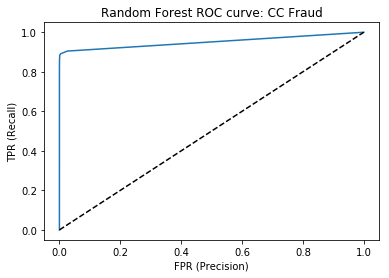

Area under curve (AUC):  0.950867303443


In [14]:
y_score = clf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)

title('Random Forest ROC curve: CC Fraud')
xlabel('FPR (Precision)')
ylabel('TPR (Recall)')

plot(fpr,tpr)
plot((0,1), ls='dashed',color='black')
plt.show()
#print 'Area under curve (AUC): ', auc(fpr,tpr)
print('Area under curve (AUC): ', auc(fpr,tpr))

### Confusion Matrix
Another valuable way to visulize our predictions is to plot them in a confusion matrix, which shows us the frequency of correct & incorrect predictions.

In [15]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap) 
    plt.title(title)
    class_labels = ['Valid','Fraudulent']
    plt.colorbar()
    
    tick_marks = np.arange(len(class_labels)) 
    plt.xticks(tick_marks, class_labels, rotation=90) 
    plt.yticks(tick_marks, class_labels) 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

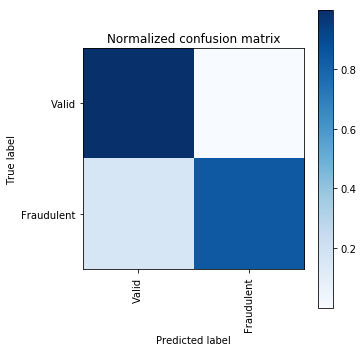

In [16]:
cm = confusion_matrix(y_test, y_test_hat)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
plt.figure(figsize=(5,5))
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

In [17]:
#Out of sample
print(cm)
print("False positive rate = ",cm[1][0]/sum(cm[1]))

[[93821    19]
 [   23   124]]
False positive rate =  0.156462585034


In [18]:
#Recheck in sample
cm = confusion_matrix(y_train0, y_train_hat)
print(cm)
print("False positive rate = ",cm[1][0]/sum(cm[1]))

[[190455     20]
 [     0    345]]
False positive rate =  0.0
